KeyboardInterrupt: 

<Figure size 640x480 with 0 Axes>

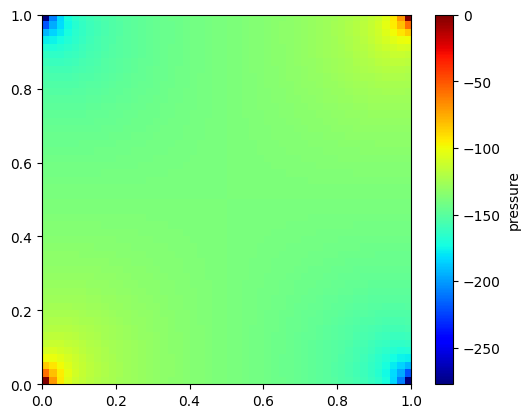

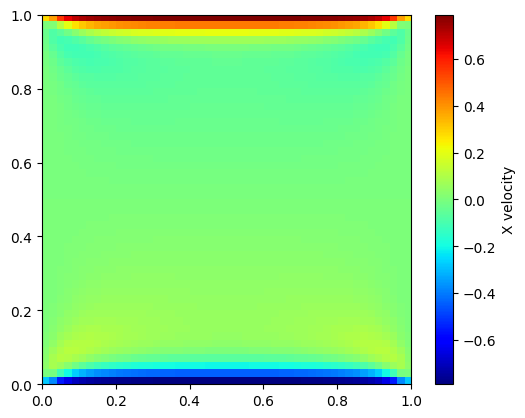

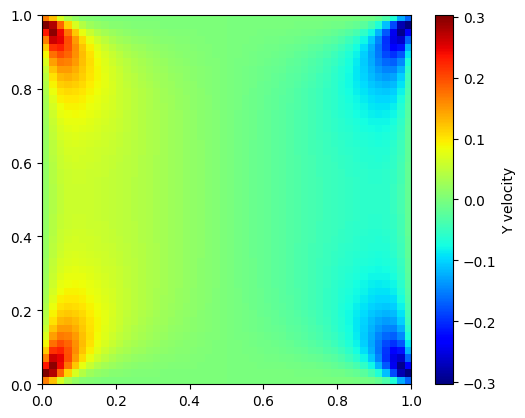

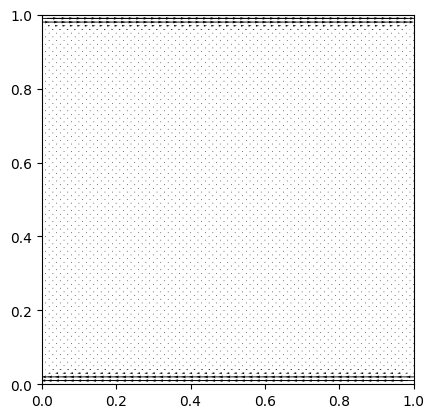

In [12]:
from fipy import CellVariable, FaceVariable, Grid2D, DiffusionTerm, Viewer
from fipy.tools import numerix

L = 1.0
N = 50
dL = L / N
viscosity = 1
U = 1.
#0.8 for pressure and 0.5 for velocity are typical relaxation values for SIMPLE
pressureRelaxation = 0.8
velocityRelaxation = 0.5
if __name__ == '__main__':
    sweeps = 300
else:
    sweeps = 5

mesh = Grid2D(nx=N, ny=N, dx=dL, dy=dL)

pressure = CellVariable(mesh=mesh, name='pressure')
pressureCorrection = CellVariable(mesh=mesh)
xVelocity = CellVariable(mesh=mesh, name='X velocity')
yVelocity = CellVariable(mesh=mesh, name='Y velocity')

velocity = FaceVariable(mesh=mesh, rank=1)

xVelocityEq = DiffusionTerm(coeff=viscosity) - pressure.grad.dot([1., 0.])
yVelocityEq = DiffusionTerm(coeff=viscosity) - pressure.grad.dot([0., 1.])

ap = CellVariable(mesh=mesh, value=1.)
coeff = 1./ ap.arithmeticFaceValue*mesh._faceAreas * mesh._cellDistances
pressureCorrectionEq = DiffusionTerm(coeff=coeff) - velocity.divergence

from fipy.variables.faceGradVariable import _FaceGradVariable
volume = CellVariable(mesh=mesh, value=mesh.cellVolumes, name='Volume')
contrvolume=volume.arithmeticFaceValue

xVelocity.constrain(0., mesh.facesRight | mesh.facesLeft)
xVelocity.constrain(U, mesh.facesTop)
xVelocity.constrain(-U, mesh.facesBottom)
yVelocity.constrain(0., mesh.exteriorFaces)
X, Y = mesh.faceCenters
pressureCorrection.constrain(0., mesh.facesLeft & (Y < dL))

if __name__ == '__main__':
    viewer = Viewer(vars=(pressure, xVelocity, yVelocity, velocity),
               xmin=0., xmax=1., ymin=0., ymax=1., colorbar='vertical', scale=5)

from builtins import range
for sweep in range(sweeps):

    ## solve the Stokes equations to get starred values
    xVelocityEq.cacheMatrix()
    xres = xVelocityEq.sweep(var=xVelocity,
                             underRelaxation=velocityRelaxation)
    xmat = xVelocityEq.matrix

    yres = yVelocityEq.sweep(var=yVelocity,
                             underRelaxation=velocityRelaxation)

    ## update the ap coefficient from the matrix diagonal
    ap[:] = -numerix.asarray(xmat.takeDiagonal())

    ## update the face velocities based on starred values with the
    ## Rhie-Chow correction.
    ## cell pressure gradient
    presgrad = pressure.grad
    ## face pressure gradient
    facepresgrad = _FaceGradVariable(pressure)

    velocity[0] = xVelocity.arithmeticFaceValue \
         + contrvolume / ap.arithmeticFaceValue * \
           (presgrad[0].arithmeticFaceValue-facepresgrad[0])
    velocity[1] = yVelocity.arithmeticFaceValue \
         + contrvolume / ap.arithmeticFaceValue * \
           (presgrad[1].arithmeticFaceValue-facepresgrad[1])
    velocity[..., mesh.exteriorFaces.value] = 0.
    velocity[0, mesh.facesTop.value] = U

    ## solve the pressure correction equation
    pressureCorrectionEq.cacheRHSvector()
    ## left bottom point must remain at pressure 0, so no correction
    pres = pressureCorrectionEq.sweep(var=pressureCorrection)
    rhs = pressureCorrectionEq.RHSvector

    ## update the pressure using the corrected value
    pressure.setValue(pressure + pressureRelaxation * pressureCorrection )
    ## update the velocity using the corrected pressure
    xVelocity.setValue(xVelocity - pressureCorrection.grad[0] / \
                                               ap * mesh.cellVolumes)
    yVelocity.setValue(yVelocity - pressureCorrection.grad[1] / \
                                               ap * mesh.cellVolumes)

    if __name__ == '__main__':
        if sweep%10 == 0:
            print('sweep:', sweep, ', x residual:', xres, \
                                 ', y residual', yres, \
                                 ', p residual:', pres, \
                                 ', continuity:', max(abs(rhs)))

            viewer.plot()